# Likelihood Ratio Test Simulation

Likelihood ratio test simulations

### Imports

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from statsmodels.stats.weightstats import DescrStatsW
import numpy as np
import itertools
import time

### Simulation functions


In [3]:
def simulate_data(mu, sigma, p, num_cells):
    
    continuous = stats.lognorm.rvs(s=sigma, scale=np.exp(mu), size=num_cells)
    ground_truth_counts = np.round(continuous).astype(np.int64)
    observed = np.random.binomial(n=ground_truth_counts, p=p)
    
    return observed

### Parameter estimation functions

In [503]:
np.log([1, 0, 3])

/anaconda3/envs/scvi/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


array([0.        ,       -inf, 1.09861229])

In [534]:
def get_parameters(observed, p_hat):
    
    mu_hat_closed = np.log(observed.mean()) - np.log(p_hat) - (1/2)*np.log(observed.var()/observed.mean()**2 - (1-p_hat)/observed.mean() + 1)
    sigma_hat_closed = np.sqrt(np.log(observed.var()/observed.mean()**2 - (1-p_hat)/observed.mean() + 1))
    
    return mu_hat_closed, sigma_hat_closed

### Log-likelihood computing functions

In [535]:
MAX_LATENT = 200
p = 0.1
binom_table = np.zeros(shape=(MAX_LATENT, MAX_LATENT))
    
for x in range(MAX_LATENT):
    for z in range(x, MAX_LATENT):
        binom_table[x, z] = stats.binom.pmf(x, z, p)

In [536]:
def rv_pmf(x, mu, sigma):
    """ PDF/PMF of the random variable under use. """
    
    return stats.lognorm.pdf(x, scale=np.exp(mu), s=sigma)

In [537]:
def create_px_table(mu, sigma, p):
    
    z_probs = np.tile(rv_pmf(np.arange(0, MAX_LATENT), mu, sigma).reshape(1, -1), [MAX_LATENT, 1])
    
    return (z_probs * binom_table).sum(axis=1)

In [682]:
def log_likelihood(observed, mu, sigma):
    
    observed = observed[observed < 200]
    observed_counts = pd.Series(observed).value_counts()
    optimal_px_table = create_px_table(mu, sigma, p)
    optimal_likelihood = np.array([count*np.log(optimal_px_table[val]) for val,count in zip(observed_counts.index, observed_counts)]).sum()
    return optimal_likelihood

### Test of Means - Different means

In [761]:
# Parameters for data generation
num_cells = 2000

mu1 = 1.5
sigma1 = 1

mu2 = 1
sigma2 = 1

p=0.1

In [769]:
# Parameters for simulation
num_trials = 5000

In [770]:
p_hat = p

Ks = np.zeros(num_trials)

mu1_hats = np.zeros(num_trials)
mu2_hats = np.zeros(num_trials)
mu_null_hats = np.zeros(num_trials)

sigma1_hats = np.zeros(num_trials)
sigma2_hats = np.zeros(num_trials)
sigma1_null_hats = np.zeros(num_trials)
sigma2_null_hats = np.zeros(num_trials)

alt_lls = np.zeros(num_trials)
null_lls = np.zeros(num_trials)


for trial in range(num_trials):
    
    observed1 = simulate_data(mu1, sigma1, p, num_cells)
    observed2 = simulate_data(mu2, sigma2, p, num_cells)
    
    mu1_hat, sigma1_hat = get_parameters(observed1, p_hat)
    mu2_hat, sigma2_hat = get_parameters(observed2, p_hat)
    
    # For comparison of the means
    mu_null_hat = (mu1_hat + mu2_hat)/2
    sigma1_null_hat = np.sqrt((sigma1_hat**2 + mu1_hat**2) - 2*mu_null_hat*mu1_hat + mu_null_hat**2)
    sigma2_null_hat = np.sqrt((sigma2_hat**2 + mu2_hat**2) - 2*mu_null_hat*mu2_hat + mu_null_hat**2)
    
    # For comparison of variances
#     sigma_null_hat = np.sqrt(sigma1_hat**2 + sigma2_hat**2)
#     mu1_null_hat = np.log(observed1.mean() / p / np.sqrt(np.exp(sigma_null_hat**2)))
#     mu2_null_hat = np.log(observed2.mean() / p / np.sqrt(np.exp(sigma_null_hat**2)))

    
    alt_ll = \
        log_likelihood(
            observed1, 
            mu1_hat, 
            sigma1_hat
        ) + \
        log_likelihood(
            observed2, 
            mu2_hat, 
            sigma2_hat)
    
    null_ll = \
        log_likelihood(
            observed1, 
            mu_null_hat, 
            sigma1_null_hat
        ) + \
        log_likelihood(
            observed2, 
            mu_null_hat, 
            sigma2_null_hat)       
    
    Ks[trial] = alt_ll - null_ll
    
    mu1_hats[trial] = mu1_hat
    mu2_hats[trial] = mu2_hat
    mu_null_hats[trial] = mu_null_hat
    
    sigma2_hats[trial] = sigma2_hat
    sigma1_hats[trial] = sigma1_hat
    sigma1_null_hats[trial] = sigma1_null_hat
    sigma2_null_hats[trial] = sigma2_null_hat
    
    alt_lls[trial] = alt_ll
    null_lls[trial] = null_ll
    
pval = stats.chi2.sf(2*Ks, df=2)

/anaconda3/envs/scvi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/envs/scvi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/envs/scvi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


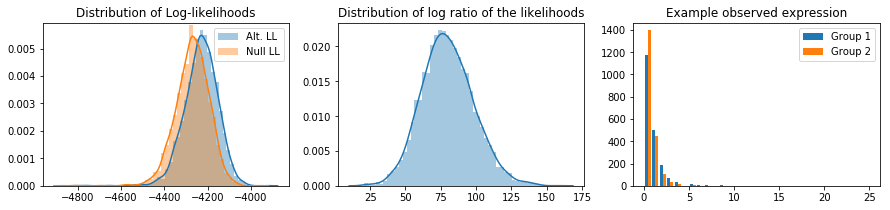

In [779]:
plt.figure(figsize=(15, 3));

plt.subplot(1, 3, 1)
sns.distplot(alt_lls[~np.isnan(alt_lls)]);
sns.distplot(null_lls[~np.isnan(null_lls)]);
plt.legend(['Alt. LL', 'Null LL']);
plt.title('Distribution of Log-likelihoods')
plt.subplot(1, 3, 2);
sns.distplot(2*Ks[~np.isnan(Ks)], bins=50);
plt.title('Distribution of log ratio of the likelihoods');
plt.subplot(1, 3, 3);
plt.hist([observed1, observed2], bins=30);
plt.title('Example observed expression');
plt.legend(['Group 1', 'Group 2'])


### Test of Means - Same means

In [780]:
# Parameters for data generation
num_cells = 2000

mu1 = 1
sigma1 = 1

mu2 = 1
sigma2 = 1

p=0.1

In [781]:
# Parameters for simulation
num_trials = 5000

In [782]:
p_hat = p

Ks = np.zeros(num_trials)

mu1_hats = np.zeros(num_trials)
mu2_hats = np.zeros(num_trials)
mu_null_hats = np.zeros(num_trials)

sigma1_hats = np.zeros(num_trials)
sigma2_hats = np.zeros(num_trials)
sigma1_null_hats = np.zeros(num_trials)
sigma2_null_hats = np.zeros(num_trials)

alt_lls = np.zeros(num_trials)
null_lls = np.zeros(num_trials)


for trial in range(num_trials):
    
    observed1 = simulate_data(mu1, sigma1, p, num_cells)
    observed2 = simulate_data(mu2, sigma2, p, num_cells)
    
    mu1_hat, sigma1_hat = get_parameters(observed1, p_hat)
    mu2_hat, sigma2_hat = get_parameters(observed2, p_hat)
    
    # For comparison of the means
    mu_null_hat = (mu1_hat + mu2_hat)/2
    sigma1_null_hat = np.sqrt((sigma1_hat**2 + mu1_hat**2) - 2*mu_null_hat*mu1_hat + mu_null_hat**2)
    sigma2_null_hat = np.sqrt((sigma2_hat**2 + mu2_hat**2) - 2*mu_null_hat*mu2_hat + mu_null_hat**2)
    
    # For comparison of variances
#     sigma_null_hat = np.sqrt(sigma1_hat**2 + sigma2_hat**2)
#     mu1_null_hat = np.log(observed1.mean() / p / np.sqrt(np.exp(sigma_null_hat**2)))
#     mu2_null_hat = np.log(observed2.mean() / p / np.sqrt(np.exp(sigma_null_hat**2)))

    
    alt_ll = \
        log_likelihood(
            observed1, 
            mu1_hat, 
            sigma1_hat
        ) + \
        log_likelihood(
            observed2, 
            mu2_hat, 
            sigma2_hat)
    
    null_ll = \
        log_likelihood(
            observed1, 
            mu_null_hat, 
            sigma1_null_hat
        ) + \
        log_likelihood(
            observed2, 
            mu_null_hat, 
            sigma2_null_hat)       
    
    Ks[trial] = alt_ll - null_ll
    
    mu1_hats[trial] = mu1_hat
    mu2_hats[trial] = mu2_hat
    mu_null_hats[trial] = mu_null_hat
    
    sigma2_hats[trial] = sigma2_hat
    sigma1_hats[trial] = sigma1_hat
    sigma1_null_hats[trial] = sigma1_null_hat
    sigma2_null_hats[trial] = sigma2_null_hat
    
    alt_lls[trial] = alt_ll
    null_lls[trial] = null_ll
    
pval = stats.chi2.sf(2*Ks, df=2)

/anaconda3/envs/scvi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/envs/scvi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/envs/scvi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


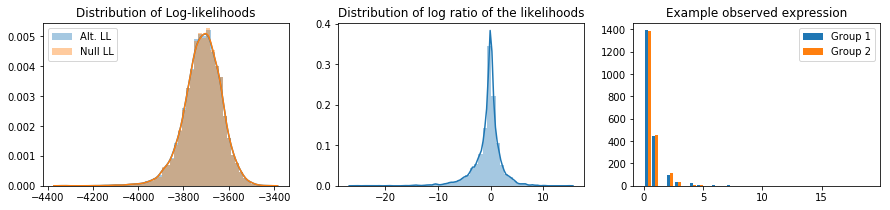

In [783]:
plt.figure(figsize=(15, 3));

plt.subplot(1, 3, 1)
sns.distplot(alt_lls[~np.isnan(alt_lls)]);
sns.distplot(null_lls[~np.isnan(null_lls)]);
plt.legend(['Alt. LL', 'Null LL']);
plt.title('Distribution of Log-likelihoods')
plt.subplot(1, 3, 2);
sns.distplot(2*Ks[~np.isnan(Ks)], bins=50);
plt.title('Distribution of log ratio of the likelihoods');
plt.subplot(1, 3, 3);
plt.hist([observed1, observed2], bins=30);
plt.title('Example observed expression');
plt.legend(['Group 1', 'Group 2'])
